<img src="img/ibidat.png" alt="drawing" width="600"/>

# Introducción

En este cuaderno hacemos un estudio de simulación de los distintos métodos de fairness que se han revisado en el TFM.

# Modelo

Vamos a generar los datos a través de una normal multivariada. En concreto:

$$
(A_l, X_l) \sim \mathcal{N}(\mu, \Sigma)
$$

donde $A_l$ representan los atributos sensibles, $X_l$ los no sensibles y $\mu$ y $\Sigma$ son parámetros de la simulación a determinar. En nuestro caso, $\mu$ será el vector nulo y $\Sigma$, la identidad. Otros parámetros a determinar son las dimensiones de nuestros datos. En concreto nosotros vamos a tomar $30$ atributos no sensibles y $1$ o $2$ sensibles según que caso estemos estudiando: Será $1$ en `Simulation_simple` y `Simulation_multalg`, mientras que en `Simulation_multsens` y `Simulation_general` usaremos $2$ atributos sensibles. Generaremos una matriz que tendrá tantas columnas como variables tengamos, y con tantas filas como observaciones queramos. En nuestro caso generaremos $1000$ observaciones.

Una vez hemos generada una matriz a partir de $(A_l, X_l)$ procederemos generando una variable más por medio de una relación lineal: 

$$
Y_l = X_l \cdot \beta + A_l \cdot \gamma
$$

Donde $\beta$ y $\gamma$ son vectores a elegir. En nuestro caso consideraremos tres escenarios diferentes:

1. Alta correlación con los atributos sensibles: donde $\gamma$ será idénticamente uno y $\beta$ será nulo.
2. Correlación moderada con los atributos sensibles: donde $\gamma$ y $\beta$ serán idénticamente uno.
3. Baja correlación con los atributos sensibles: donde $\gamma$ será nulo y $\beta$ será identicamente uno.

Vamos a tratar con variables binarias por simplicidad. Así pues, las variables con subíndice l que hemos generado representan las log-odds de las probabilidades de las variables reales. De tal modo, deshaciendo esta transformación por medio de la función logística obtendremos las probabilidades de las variables, es decir:

$$
p_J = logit(J_l) \quad \quad J \in \{Y, X, A\}
$$

Así pues, al elemento $x_{ij}$ de nuestro dataset le asignaremos un uno con probabilidad dada por la función logística aplicado al correspondiente elemento de la matriz generada a partir de una normal con los parámetros especificados. Una vez que hayamos convertido los valores simulados en unos y ceros, habremos obtenido ya nuestro dataset real: las variables reales $Y, X, A$ son aquellas generadas de esta forma.

# Carga de librerías


In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

#Simulacion
from aif360.datasets import BinaryLabelDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook
np.random.seed(seed)

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

# Simulación de dataset.

El siguiente bloque permite generar el conjunto de datos sobre el que vamos a trabajar.


In [3]:
def logit(x):
    return np.log(x/(1-x))

def inv_logit(x):
    return np.exp(x)/(1+np.exp(x))

def simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma):
    
    p = n_var + n_sens
    coef = np.concatenate((gamma, beta))
        
    X = np.random.multivariate_normal(mean_vec, cov, size = n_obs)
    probs_var = inv_logit(X)
    bin = np.random.binomial(1, probs_var)
    
    probs_Y = inv_logit(coef.dot(X.T))
    Y = np.random.binomial(1, probs_Y)
    
    names = ['0' for i in range(p+1)]
    sens = ['0' for i in range(n_sens)]
    var = 1
    
    names[0] = 'response'
    
    for i in range(1,p+1):
        if i-1 < n_sens:
            sens[i-1] = 'sens ' + str(i)
            names[i] = 'sens ' + str(i)
        if i-1 >= n_sens:
            names[i] = 'var ' + str(var)
            var += 1
    
    names = np.array(names)
    sens = np.array(sens)
    response = np.array(['response'])
    
    Y = Y.reshape((n_obs,1))
    
    bin = np.concatenate((Y, bin), axis = 1)
    
    data_pd = pd.DataFrame(bin, columns = names)
    data = BinaryLabelDataset(df = data_pd, favorable_label = 1, unfavorable_label = 0, label_names = response, protected_attribute_names = sens)
    return data

In [4]:
n_obs = 1000
n_var = 30
n_sens = 1
mean_vec = np.zeros(n_var+n_sens)
cov = np.identity(n_var+n_sens)
beta = np.ones(n_var)
gamma = np.zeros(n_sens)

dataset = simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma)

#dataset.favorable_label = 1
#dataset.unfavorable_label = 0

# Separamos el conjunto de datos en train, validate, test
data_train, vt = dataset.split([0.7], shuffle=True, seed=seed)
data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

# Obtenemos los indicadores del grupo sensible
sensitive_attribute = dataset.protected_attribute_names[0]
privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset)
    
print(f'Dimensiones del conjunto de datos: {dataset.features.shape}')
print("Grupos privilegiados:", privileged_groups)
print("Grupos no privilegiados:", unprivileged_groups)
print("Label del grupo favorable:", dataset.favorable_label)
print("Label del grupo desfavorable:", dataset.unfavorable_label)

Dimensiones del conjunto de datos: (1000, 31)
Grupos privilegiados: [{'sens 1': 1.0}]
Grupos no privilegiados: [{'sens 1': 0.0}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


## Modelos
Para esta sección, creamos un diccionario de métricas y modelos para poder acceder los resultados de todos los modelos.

In [5]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

### Regresión Logística

In [6]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: user 8.39 ms, sys: 0 ns, total: 8.39 ms
Wall time: 8.28 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5405
Balanced accuracy: 0.5425
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.0187
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0345
Sufficiency ( |ΔPPV| ) : 0.1266
CPU times: user 167 ms, sys: 13.7 ms, total: 180 ms
Wall time: 178 ms


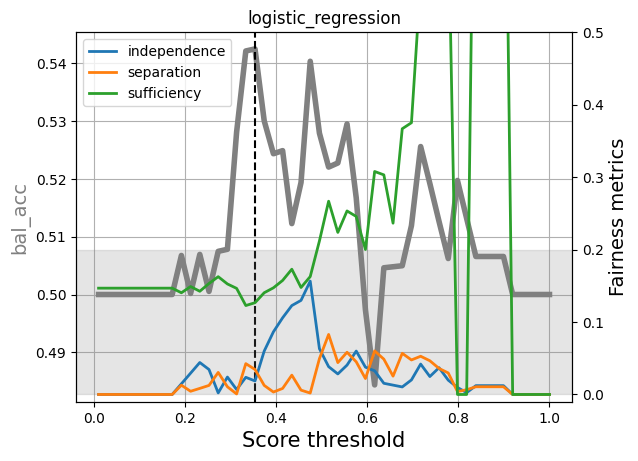

In [7]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [8]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.6998
Balanced accuracy: 0.5982
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.1461
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0726
Sufficiency ( |ΔPPV| ) : 0.1637


### XGBoost

In [9]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: user 1h 7min 6s, sys: 3.45 s, total: 1h 7min 9s
Wall time: 8min 27s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5740
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0047
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.1325
CPU times: user 2.98 s, sys: 52.3 ms, total: 3.03 s
Wall time: 620 ms


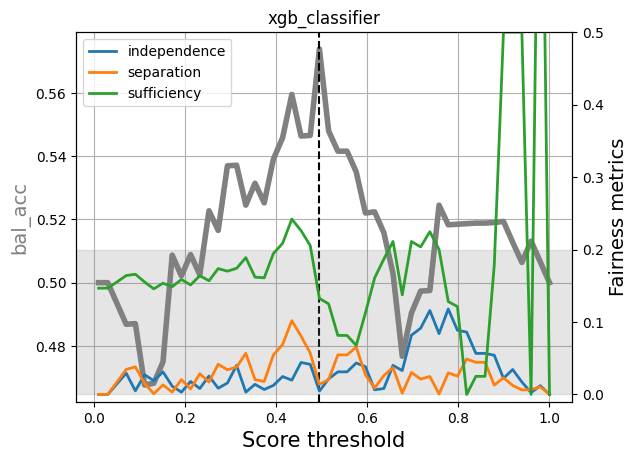

In [10]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


In [11]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5932
Balanced accuracy: 0.5768
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.1223
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0323
Sufficiency ( |ΔPPV| ) : 0.1658


## Técnicas de preprocesado

### Reponderación

In [12]:
%%time 
# Nombramos al modelo
fairness_method = '_reweighting'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_copy = PreProcessor.transform(data_train_copy)
data_val_copy = PreProcessor.transform(data_val_copy)
data_test_copy = PreProcessor.transform(data_test_copy)

CPU times: user 9.98 ms, sys: 5 µs, total: 9.99 ms
Wall time: 10.3 ms


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3131
AUC: 0.5574
Balanced accuracy: 0.5641
Accuracy: 0.5718
Independence ( |ΔP(Y_pred = 1)| ): 0.0970
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0450
Sufficiency ( |ΔPPV| ) : 0.1905
CPU times: user 203 ms, sys: 28.1 ms, total: 231 ms
Wall time: 468 ms


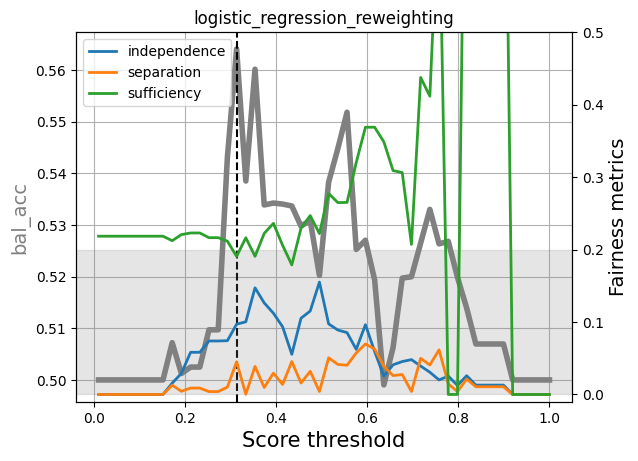

In [13]:
%%time 

# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5730
Accuracy: 0.5720
Independence ( |ΔP(Y_pred = 1)| ): 0.0063
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.2027
CPU times: user 1h 5min 35s, sys: 3.49 s, total: 1h 5min 38s
Wall time: 6min 3s


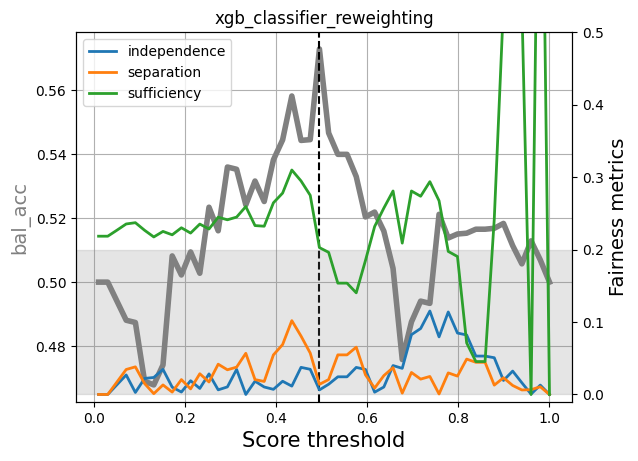

In [14]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


### Eliminador de impacto dispar

In [15]:
%%time 
# Nombramos al modelo
fairness_method = '_di_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_copy = PreProcessor.fit_transform(data_train_copy)
data_val_copy = PreProcessor.fit_transform(data_val_copy)
data_test_copy = PreProcessor.fit_transform(data_test_copy)



CPU times: user 196 ms, sys: 24 ms, total: 220 ms
Wall time: 436 ms


Aplicamos los métodos de regresión logística y XGBoost

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5405
Balanced accuracy: 0.5425
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.0187
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0345
Sufficiency ( |ΔPPV| ) : 0.1266
CPU times: user 312 ms, sys: 152 ms, total: 465 ms
Wall time: 1.29 s


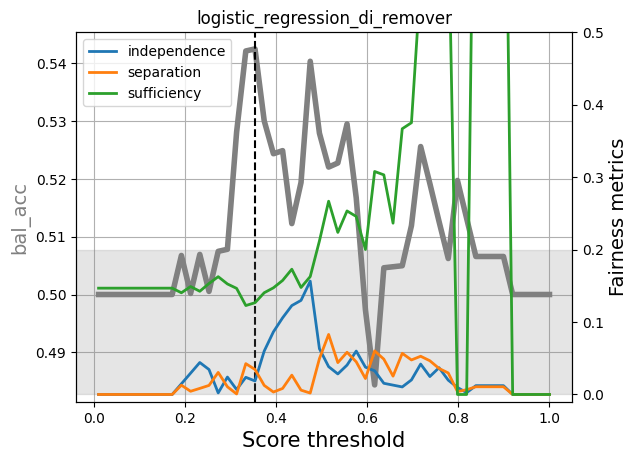

In [16]:
%%time 
# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5740
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0047
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.1325
CPU times: user 1h 6min 4s, sys: 3.33 s, total: 1h 6min 7s
Wall time: 6min 4s


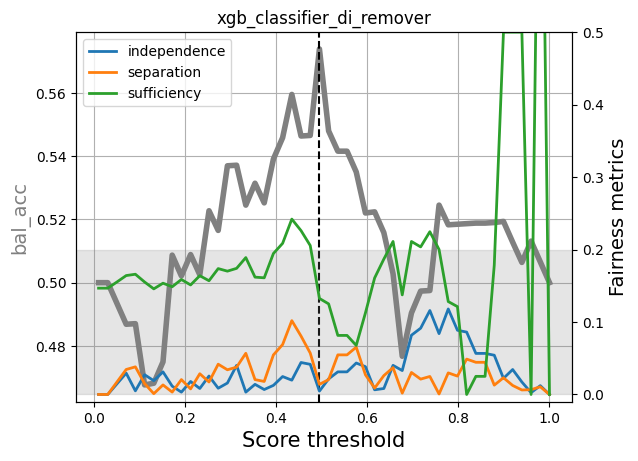

In [17]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])


# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


## Técnicas de inprocesado

### Eliminador de prejuicios por regularización

In [18]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [19]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

### Algoritmo de metafairness

In [20]:
%%time 
# Nombramos al modelo
model_name = 'meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:36: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:37: RuntimeWarning: invalid value encountered in divide
  prob_z_0 = (prob_m1_0 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:38: RuntimeWarning: invalid value encountered in divide
  prob_z_1 = (prob_m1_1 + prob_1_1) / total


TypeError: cannot unpack non-iterable NoneType object

In [21]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Eliminación de prejuicios adversarios

In [22]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

2024-06-14 08:34:27.223017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2024-06-14 08:34:27.820418: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.744105; batch adversarial loss: 0.713970
epoch 1; iter: 0; batch classifier loss: 0.690153; batch adversarial loss: 0.706501
epoch 2; iter: 0; batch classifier loss: 0.696660; batch adversarial loss: 0.777555
epoch 3; iter: 0; batch classifier loss: 0.692590; batch adversarial loss: 0.755478
epoch 4; iter: 0; batch classifier loss: 0.680635; batch adversarial loss: 0.738805
epoch 5; iter: 0; batch classifier loss: 0.688001; batch adversarial loss: 0.725242
epoch 6; iter: 0; batch classifier loss: 0.681196; batch adversarial loss: 0.778612
epoch 7; iter: 0; batch classifier loss: 0.676553; batch adversarial loss: 0.756587
epoch 8; iter: 0; batch classifier loss: 0.678415; batch adversarial loss: 0.753371
epoch 9; iter: 0; batch classifier loss: 0.669034; batch adversarial loss: 0.761764
epoch 10; iter: 0; batch classifier loss: 0.685406; batch adversarial loss: 0.748950
epoch 11; iter: 0; batch classifier loss: 0.672687; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4141
AUC: 0.5994
Balanced accuracy: 0.5976
Accuracy: 0.6000
Independence ( |ΔP(Y_pred = 1)| ): 0.5983
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0509
Sufficiency ( |ΔPPV| ) : 0.0481
CPU times: user 347 ms, sys: 464 ms, total: 811 ms
Wall time: 416 ms


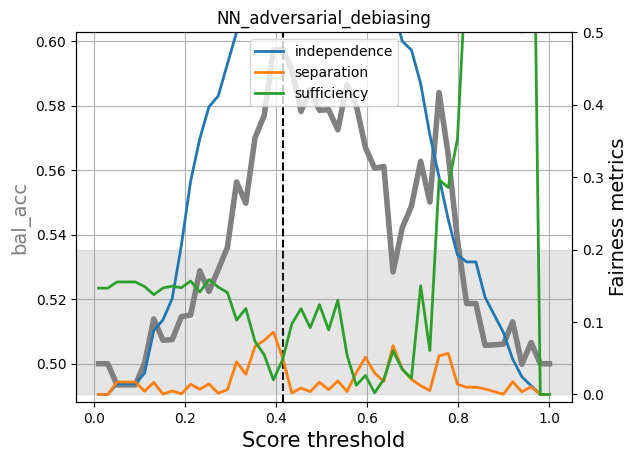

In [23]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios 

In [24]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.708579
epoch 1; iter: 0; batch classifier loss: 0.708955
epoch 2; iter: 0; batch classifier loss: 0.669421
epoch 3; iter: 0; batch classifier loss: 0.681439
epoch 4; iter: 0; batch classifier loss: 0.680147
epoch 5; iter: 0; batch classifier loss: 0.680275
epoch 6; iter: 0; batch classifier loss: 0.636913
epoch 7; iter: 0; batch classifier loss: 0.651361
epoch 8; iter: 0; batch classifier loss: 0.666430
epoch 9; iter: 0; batch classifier loss: 0.655140
epoch 10; iter: 0; batch classifier loss: 0.647285
epoch 11; iter: 0; batch classifier loss: 0.619546
epoch 12; iter: 0; batch classifier loss: 0.625488
epoch 13; iter: 0; batch classifier loss: 0.609579
epoch 14; iter: 0; batch classifier loss: 0.644327
epoch 15; iter: 0; batch classifier loss: 0.638136
epoch 16; iter: 0; batch classifier loss: 0.610953
epoch 17; iter: 0; batch classifier loss: 0.632899
epoch 18; iter: 0; batch classifier loss: 0.595215
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5516
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0520
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0590
Sufficiency ( |ΔPPV| ) : 0.1956
CPU times: user 186 ms, sys: 8 ms, total: 194 ms
Wall time: 297 ms


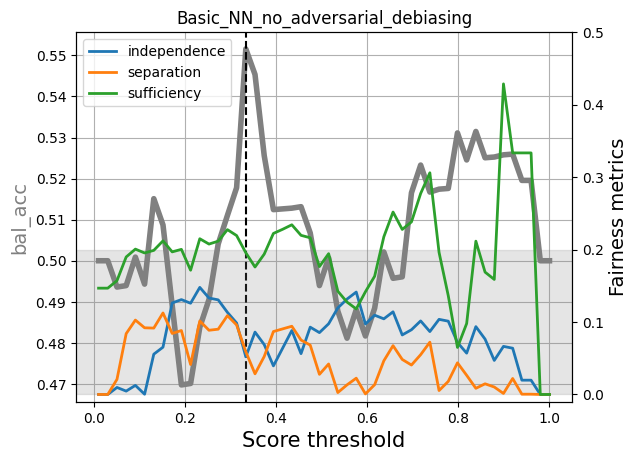

In [25]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Técnicas de postprocesado 

### Clasificación de rechazo de opción

In [26]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 14.7 s, sys: 2.07 s, total: 16.8 s
Wall time: 24.9 s


In [27]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.5148
AUC: 0.5405
Balanced accuracy: 0.5352
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.0936
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0506
Sufficiency ( |ΔPPV| ) : 0.2078


logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.4258
AUC: 0.5405
Balanced accuracy: 0.5386
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.0606
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0113
Sufficiency ( |ΔPPV| ) : 0.1346


logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.5445
AUC: 0.5405
Balanced accuracy: 0.5290
Accuracy: 0.5267
Independence ( |ΔP(Y_pred = 1)| ): 0.0864
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0481
Sufficiency ( |ΔPPV| ) : 0.2123




In [28]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 19 s, sys: 188 ms, total: 19.2 s
Wall time: 27.1 s


In [29]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5354
Balanced accuracy: 0.4957
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.1011
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0120
Sufficiency ( |ΔPPV| ) : 0.1403


xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590


xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590




### Escalado de Platt por grupos

In [30]:
%%time
fairness_method = '_platt_scaling'
model_names = ['logistic_regression', 'xgb_classifier']
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name], class_thresh = model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                             'unpriv': [data_val_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data.items():

        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()

        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                  data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        
        # Evaluamos a los modelos para el rango de umbrales
    thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                     np.max(data_val_preds2.scores.ravel()),
                                     50)

    metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores(
            dataset_true = data_val_copy,
            dataset_preds = data_val_preds2,
            thresh_arr = thresh_sweep_platt
        )

    # Evaluamos las métricas para el mejor umbral y las guardamos
    metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    print('\nValidation set results for {}'.format(model_name))
    utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
    # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
    # plt.title( model_name+fairness_method )
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
    a.set_title(model_name+fairness_method )
    f



Validation set results for logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.5477
AUC: 0.5964
Balanced accuracy: 0.5866
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.9268
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0359
Sufficiency ( |ΔPPV| ) : 0.5921

Validation set results for xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.5683
AUC: 0.5930
Balanced accuracy: 0.5894
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.5366
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0942
Sufficiency ( |ΔPPV| ) : 0.6591
CPU times: user 1.77 s, sys: 56 ms, total: 1.83 s
Wall time: 526 ms


In [31]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name], class_thresh = model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

### Procesador de probabilidades igualadas

#### Usando labels

In [32]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [33]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [34]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [35]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [36]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 531 ms, sys: 1.9 s, total: 2.44 s
Wall time: 154 ms


In [37]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.4747
AUC: 0.5405
Balanced accuracy: 0.5471
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1686
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0123
Sufficiency ( |ΔPPV| ) : 0.1826


Results for logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.5405
Balanced accuracy: 0.5514
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.2683
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0596
Sufficiency ( |ΔPPV| ) : 0.6818


Results for logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5405
Balanced accuracy: 0.5411
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1765
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0637
Sufficiency ( |ΔPPV| ) : 0.1089




In [38]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 4.08 s, sys: 15.6 ms, total: 4.1 s
Wall time: 273 ms


In [39]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5740
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0047
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.1325


Results for xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5738
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0341
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0184
Sufficiency ( |ΔPPV| ) : 0.1335


Results for xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5875
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.0291
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0146
Sufficiency ( |ΔPPV| ) : 0.1696




## Comparación de modelos

Podemos usar los diccionarios que resumen la calidad de los modelos fair para compararlos todos.

### Resultados en validación

In [40]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.353469,0.542496,0.546667,0.018651,0.034481,0.126623,0.540541
xgb_classifier,0.494898,0.573969,0.573333,0.004663,0.013950,0.132520,0.535384
logistic_regression_reweighting,0.313061,0.564056,0.571812,0.096984,0.045036,0.190519,0.557432
xgb_classifier_reweighting,0.494898,0.573004,0.572032,0.006324,0.013950,0.202669,0.535384
logistic_regression_di_remover,0.353469,0.542496,0.546667,0.018651,0.034481,0.126623,0.540541
xgb_classifier_di_remover,0.494898,0.573969,0.573333,0.004663,0.013950,0.132520,0.535384
NN_adversarial_debiasing,0.414082,0.597617,0.600000,0.598278,0.050893,0.048077,0.599395
Basic_NN_no_adversarial_debiasing,0.333265,0.551565,0.553333,0.052009,0.058968,0.195556,0.516003
logistic_regression_reject_option_spd,0.514848,0.535206,0.533333,0.093615,0.050649,0.207792,0.540541
logistic_regression_reject_option_aod,0.425758,0.538585,0.540000,0.060617,0.011327,0.134615,0.540541


### Resultados en test

In [41]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.353469,0.598214,0.580000,0.146104,0.072590,0.163741,0.699821
xgb_classifier,0.494898,0.576786,0.580000,0.122294,0.032318,0.165775,0.593214
logistic_regression_reweighting,0.313061,0.568611,0.548828,0.004951,0.009913,0.183283,0.715179
xgb_classifier_reweighting,0.494898,0.571906,0.574605,0.110448,0.032318,0.236147,0.593214
logistic_regression_di_remover,0.353469,0.598214,0.580000,0.146104,0.072590,0.163741,0.699821
xgb_classifier_di_remover,0.494898,0.576786,0.580000,0.122294,0.032318,0.165775,0.593214
NN_adversarial_debiasing,0.414082,0.532143,0.520000,0.564935,0.059158,0.041667,0.629107
Basic_NN_no_adversarial_debiasing,0.333265,0.573214,0.566667,0.076840,0.018268,0.098278,0.608036
logistic_regression_reject_option_spd,0.514848,0.647321,0.653333,0.037879,0.160837,0.291429,0.699821
logistic_regression_reject_option_aod,0.425758,0.649107,0.640000,0.009740,0.031163,0.129314,0.699821


In [42]:
algorithm_performance_summary.to_csv('SIMULATION_SIMPLE_low', index = True, sep=',', encoding='utf-8')